# Data integration of district level data #
[NCES data](https://nces.ed.gov/ccd/elsi/tableGenerator.aspx), [STAAR data](https://tea.texas.gov/student-assessment/testing/staar/staar-aggregate-data), [Covid data](https://dshs.texas.gov/coronavirus/schools/texas-education-agency/), ADA data, [LAUS data](https://www.bls.gov/lau/#cntyaa),  [Census Block Group 2010 TX](https://schoolsdata2-93b5c-tea-texas.opendata.arcgis.com/datasets/census-block-group-2010-tx/), [ESSER data](https://tea.texas.gov/finance-and-grants/grants/grants-administration/applying-for-a-grant/entitlements)

This notebook is following these steps:

1. Integrating cleaned data from 7 different sources:
    - [NCES](https://nces.ed.gov/ccd/elsi/tableGenerator.aspx): DATA_NCES_DISTRICT.csv
    - [STAAR](https://tea.texas.gov/student-assessment/testing/staar/staar-aggregate-data): 
        - DATA_STAAR_DISTRICT_2019.csv
        - DATA_STAAR_DISTRICT_2021.csv
    - [Covid](https://dshs.texas.gov/coronavirus/schools/texas-education-agency/): 
        - DATA_COVID_DISTRICT.csv
        - DATA_COVID_COUNTY.csv
    - [LAUS(Local Area Unemployment Statistics)](https://www.bls.gov/lau/#cntyaa):
        - DATA_LAUS_COUNTY.csv
    - ADA: DATA_ADA_DISTRICT.csv
    - [Census Block Group 2010](https://schoolsdata2-93b5c-tea-texas.opendata.arcgis.com/datasets/census-block-group-2010-tx/): 
        - DATA_Census_Block_Group_2010_TX_County.csv
    - [ESSER](https://tea.texas.gov/finance-and-grants/grants/grants-administration/applying-for-a-grant/entitlements)
        - DATA_ESSER_DISTRICT.csv     
      
2. Normalization: Normalizing numberical data into a percentage.  

3. Calculating Delta: Getting differences for the important variables having both values for 2018-2019 and 2020-2021  

4. Labeling: Creating 3 classes for Learning Loss  

5. Exporting: Creating a csv file for purposes:
    - DATA_Texas_District_v3.csv: keeping all missing values with normalization and delta values for Grandient Boosting modeling
    
    
Note: List of variables is [here](https://git.txstate.edu/DataLab/data-NCES/blob/master/CHERR/EDA/DATA_Texas_District_List_of_Variables.csv).   

Note: All raw data was processed/cleaned from [here](https://git.txstate.edu/DataLab/data-NCES/blob/master/data).

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Reading [NCES data](https://nces.ed.gov/ccd/elsi/tableGenerator.aspx) ##

### NCES District ###

In [2]:
df_nces = pd.read_csv('../../data/nces/DATA_NCES_DISTRICT_v4.csv')
print('Shape:', df_nces.shape)
df_nces.info()

Shape: (1245, 66)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1245 entries, 0 to 1244
Data columns (total 66 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   Agency Name                                         1245 non-null   object 
 1   State                                               1245 non-null   object 
 2   NCES Agency ID                                      1245 non-null   float64
 3   County #                                            1245 non-null   float64
 4   Total Operational Public Schools 2018-2019          1230 non-null   float64
 5   Total Public Schools 2018-2019                      1209 non-null   float64
 6   Total Students 2018-2019                            1204 non-null   float64
 7   FTE Teachers 2018-2019                              1218 non-null   float64
 8   Total Staff 2018-2019                               1223 non

In [3]:
temp=[c + ': ' + str(df_nces[c].isna().sum()) for c in df_nces if df_nces[c].isna().any()]
temp

['Total Operational Public Schools 2018-2019: 15',
 'Total Public Schools 2018-2019: 36',
 'Total Students 2018-2019: 41',
 'FTE Teachers 2018-2019: 27',
 'Total Staff 2018-2019: 22',
 'Total Operational Public Schools 2020-2021: 10',
 'Total Public Schools 2020-2021: 31',
 'Total Students 2020-2021: 37',
 'FTE Teachers 2020-2021: 26',
 'Total Staff 2020-2021: 19',
 'Free Lunch 2020-2021: 36',
 'Free Lunch 2018-2019: 36',
 'Reduced-price Lunch 2020-2021: 36',
 'Reduced-price Lunch 2018-2019: 36',
 'Asian or Asian/Pacific Islander Students 2020-2021: 36',
 'Asian or Asian/Pacific Islander Students 2018-2019: 36',
 'Hispanic Students 2020-2021: 36',
 'Hispanic Students 2018-2019: 36',
 'Black or African American Students 2020-2021: 36',
 'Black or African American Students 2018-2019: 36',
 'White Students 2020-2021: 36',
 'White Students 2018-2019: 36',
 'Total Race/Ethnicity 2020-2021: 36',
 'Total Race/Ethnicity 2018-2019: 36',
 'School-wide Title I 2020-2021: 36',
 'School-wide Title 

In [4]:
df_nces.dropna().shape

(999, 66)

## Reading [LAUS(Local Area Unemployment Statistics) Data ](https://www.bls.gov/lau/#cntyaa)  ##

In [5]:
df_laus = pd.read_csv('../../data/laus/DATA_LAUS_COUNTY.csv')
print('Shape:', df_laus.shape)
df_laus.info()

Shape: (254, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 254 entries, 0 to 253
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Labor Force 19         254 non-null    int64  
 1   Employed 19            254 non-null    int64  
 2   Unemployed Level 19    254 non-null    int64  
 3   Unemployed Rate 19     254 non-null    float64
 4   County #               254 non-null    int64  
 5   Labor Force 21         254 non-null    int64  
 6   Employed 21            254 non-null    int64  
 7   Unemployed Level 21    254 non-null    int64  
 8   Unemployed Rate 21     254 non-null    float64
 9   Labor Force Diff       254 non-null    float64
 10  Employed Diff          254 non-null    float64
 11  Unemployed Level Diff  254 non-null    float64
 12  Unemployed Rate Diff   254 non-null    float64
dtypes: float64(6), int64(7)
memory usage: 25.9 KB


## Reading [STAAR data](https://tea.texas.gov/student-assessment/testing/staar/staar-aggregate-data) ##

### 2019 ###

In [6]:
df_staar19 = pd.read_csv('../../data/staar/DATA_STAAR_DISTRICT_2019.csv')
print('Shape:', df_staar19.shape)
print('Nunique District #:', df_staar19['District #'].nunique())
df_staar19.head()

Shape: (1184, 217)
Nunique District #: 1184


,District #,r_all_d_g3_2019,r_ethh_d_g3_2019,r_etha_d_g3_2019,r_ethb_d_g3_2019,r_ethw_d_g3_2019,r_ecoy_d_g3_2019,r_eco1_d_g3_2019,r_ti1y_d_g3_2019,r_spey_d_g3_2019,...,r_spey_rs_g8_2019,m_all_rs_g8_2019,m_ethh_rs_g8_2019,m_etha_rs_g8_2019,m_ethb_rs_g8_2019,m_ethw_rs_g8_2019,m_ecoy_rs_g8_2019,m_eco1_rs_g8_2019,m_ti1y_rs_g8_2019,m_spey_rs_g8_2019
0,1902,46.0,3.0,0.0,3.0,38.0,23.0,17.0,46.0,7.0,...,NaN,1744.0,NaN,NaN,NaN,1742.0,1720.0,1682.0,1744.0,NaN
1,1903,94.0,10.0,0.0,5.0,76.0,55.0,52.0,94.0,6.0,...,1623.0,1678.0,1748.0,NaN,1624.0,1676.0,1658.0,1653.0,1678.0,1576.0
2,1904,55.0,5.0,1.0,6.0,40.0,34.0,34.0,55.0,5.0,...,1563.0,1686.0,NaN,NaN,1608.0,1709.0,1654.0,1643.0,1686.0,1608.0
3,1906,25.0,5.0,0.0,2.0,16.0,10.0,10.0,25.0,2.0,...,NaN,1755.0,NaN,NaN,NaN,1759.0,1745.0,1740.0,1755.0,NaN
4,1907,206.0,76.0,2.0,58.0,60.0,157.0,148.0,206.0,20.0,...,1529.0,1722.0,1740.0,NaN,1667.0,1741.0,1693.0,1687.0,1722.0,1601.0


In [7]:
cols_staar19_all = ['r_all_rs_g3_2019' ,
                    'r_all_d_g3_2019' ,
                    'm_all_rs_g3_2019' ,
                    'm_all_d_g3_2019' ,
                    'r_all_rs_g4_2019' ,
                    'r_all_d_g4_2019' ,
                    'm_all_rs_g4_2019' ,
                    'm_all_d_g4_2019' ,
                    'r_all_rs_g5_2019' ,
                    'r_all_d_g5_2019' ,
                    'm_all_rs_g5_2019' ,
                    'm_all_d_g5_2019' ,
                    'r_all_rs_g6_2019' ,
                    'r_all_d_g6_2019' ,
                    'm_all_rs_g6_2019' ,
                    'm_all_d_g6_2019' ,
                    'r_all_rs_g7_2019' ,
                    'r_all_d_g7_2019' ,
                    'm_all_rs_g7_2019' ,
                    'm_all_d_g7_2019' ,
                    'r_all_rs_g8_2019' ,
                    'r_all_d_g8_2019' ,
                    'm_all_rs_g8_2019' ,
                    'm_all_d_g8_2019']

In [8]:
df_staar19[cols_staar19_all].isna().sum()

r_all_rs_g3_2019    32
r_all_d_g3_2019     22
m_all_rs_g3_2019    32
m_all_d_g3_2019     22
r_all_rs_g4_2019    35
r_all_d_g4_2019     21
m_all_rs_g4_2019    35
m_all_d_g4_2019     21
r_all_rs_g5_2019    34
r_all_d_g5_2019     24
m_all_rs_g5_2019    34
m_all_d_g5_2019     24
r_all_rs_g6_2019    31
r_all_d_g6_2019     21
m_all_rs_g6_2019    31
m_all_d_g6_2019     21
r_all_rs_g7_2019    47
r_all_d_g7_2019     34
m_all_rs_g7_2019    48
m_all_d_g7_2019     34
r_all_rs_g8_2019    47
r_all_d_g8_2019     36
m_all_rs_g8_2019    60
m_all_d_g8_2019     36
dtype: int64

### 2021 ###

In [9]:
df_staar21 = pd.read_csv('../../data/staar/DATA_STAAR_DISTRICT_2021.csv')
print('Shape:', df_staar21.shape)
print('Nunique District #:', df_staar21['District #'].nunique())
df_staar21.head()

Shape: (1182, 217)
Nunique District #: 1182


,District #,r_all_d_g3_2021,r_ethh_d_g3_2021,r_etha_d_g3_2021,r_ethb_d_g3_2021,r_ethw_d_g3_2021,r_ecoy_d_g3_2021,r_eco1_d_g3_2021,r_ti1y_d_g3_2021,r_spey_d_g3_2021,...,r_spey_rs_g8_2021,m_all_rs_g8_2021,m_ethh_rs_g8_2021,m_etha_rs_g8_2021,m_ethb_rs_g8_2021,m_ethw_rs_g8_2021,m_ecoy_rs_g8_2021,m_eco1_rs_g8_2021,m_ti1y_rs_g8_2021,m_spey_rs_g8_2021
0,1902,26.0,1.0,0.0,1.0,24.0,7.0,6.0,26.0,4.0,...,NaN,1724.0,1767.0,NaN,NaN,1719.0,1676.0,1680.0,1724.0,NaN
1,1903,95.0,6.0,0.0,0.0,86.0,44.0,41.0,95.0,8.0,...,1537.0,1659.0,1678.0,NaN,1603.0,1668.0,1648.0,1651.0,1659.0,1531.0
2,1904,45.0,5.0,0.0,4.0,34.0,24.0,23.0,45.0,5.0,...,1508.0,1694.0,1685.0,NaN,1683.0,1704.0,1701.0,1688.0,1694.0,1594.0
3,1906,24.0,4.0,0.0,3.0,17.0,11.0,9.0,24.0,1.0,...,NaN,1773.0,NaN,NaN,NaN,1763.0,1696.0,1674.0,1773.0,NaN
4,1907,182.0,73.0,1.0,63.0,41.0,142.0,114.0,182.0,24.0,...,1506.0,1700.0,1711.0,NaN,1670.0,1705.0,1691.0,1688.0,1700.0,1573.0


In [10]:
cols_staar21_all = ['r_all_rs_g3_2021',
                'r_all_d_g3_2021',
                'm_all_rs_g3_2021',
                'm_all_d_g3_2021',
                'r_all_rs_g4_2021',
                'r_all_d_g4_2021',
                'm_all_rs_g4_2021',
                'm_all_d_g4_2021',
                'r_all_rs_g5_2021',
                'r_all_d_g5_2021',
                'm_all_rs_g5_2021',
                'm_all_d_g5_2021',
                'r_all_rs_g6_2021',
                'r_all_d_g6_2021',
                'm_all_rs_g6_2021',
                'm_all_d_g6_2021',
                'r_all_rs_g7_2021',
                'r_all_d_g7_2021',
                'm_all_rs_g7_2021',
                'm_all_d_g7_2021',
                'r_all_rs_g8_2021',
                'r_all_d_g8_2021',
                'm_all_rs_g8_2021',
                'm_all_d_g8_2021']

In [11]:
df_staar21[cols_staar21_all].isna().sum()

r_all_rs_g3_2021    34
r_all_d_g3_2021     22
m_all_rs_g3_2021    34
m_all_d_g3_2021     22
r_all_rs_g4_2021    34
r_all_d_g4_2021     22
m_all_rs_g4_2021    35
m_all_d_g4_2021     22
r_all_rs_g5_2021    32
r_all_d_g5_2021     20
m_all_rs_g5_2021    32
m_all_d_g5_2021     20
r_all_rs_g6_2021    32
r_all_d_g6_2021     21
m_all_rs_g6_2021    32
m_all_d_g6_2021     21
r_all_rs_g7_2021    45
r_all_d_g7_2021     34
m_all_rs_g7_2021    50
m_all_d_g7_2021     34
r_all_rs_g8_2021    51
r_all_d_g8_2021     36
m_all_rs_g8_2021    71
m_all_d_g8_2021     36
dtype: int64

## Reading [Covid data](https://dshs.texas.gov/coronavirus/schools/texas-education-agency/) ##

### Covid District ###

In [12]:
col_covid_dist=['District #',
                'District Enrollment 01/29/21',
                'Approx. District On-Campus Enrollment 01/29/21',
                'District Enrollment 10/30/20',
                'Approx. District On-Campus Enrollment 10/30/20',
                'District Enrollment 09/28/20',
                'Approx. District On-Campus Enrollment 09/28/20']
#                 'District Enrollment First Week',
#                 'Approx. District On-Campus Enrollment First Week']

In [13]:
df_covid_dist = pd.read_csv('../../data/covid/DATA_COVID_DISTRICT.csv', usecols=col_covid_dist)
print('Shape:', df_covid_dist.shape)
df_covid_dist.head()

Shape: (1216, 7)


,District Enrollment 01/29/21,Approx. District On-Campus Enrollment 01/29/21,District Enrollment 10/30/20,Approx. District On-Campus Enrollment 10/30/20,District Enrollment 09/28/20,Approx. District On-Campus Enrollment 09/28/20,District #
0,541.0,527.0,535.0,489.0,544.0,415.0,1902.0
1,1167.0,1120.0,1200.0,1092.0,1207.0,1095.0,1903.0
2,756.0,719.0,836.0,768.0,760.0,688.0,1904.0
3,338.0,325.0,339.0,339.0,317.0,313.0,1906.0
4,3347.0,3124.0,3399.0,2908.0,3384.0,2857.0,1907.0


In [14]:
temp=[c + ': ' + str(df_covid_dist[c].isna().sum()) for c in df_covid_dist if df_covid_dist[c].isna().any()]
temp

['District Enrollment 01/29/21: 9',
 'Approx. District On-Campus Enrollment 01/29/21: 9',
 'District Enrollment 10/30/20: 9',
 'Approx. District On-Campus Enrollment 10/30/20: 9',
 'District Enrollment 09/28/20: 14',
 'Approx. District On-Campus Enrollment 09/28/20: 14',
 'District #: 1']

### Covid County ###

In [15]:
df_nces['County #'].nunique()

253

In [16]:
df_covid_county = pd.read_csv('../../data/covid/DATA_COVID_COUNTY.csv')
print('Shape:', df_covid_county.shape)
df_covid_county.head()

Shape: (255, 9)


,Unnamed: 0,County #,Confirmed Deaths 09/28/20,Confirmed Deaths 10/30/20,Confirmed Deaths 01/29/21,Confirmed Cases 09/28/20,Confirmed Cases 10/30/20,Confirmed Cases 01/29/21,County Population
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,48001.0,37.0,44.0,99.0,2840.0,2970.0,5804.0,57735.0
2,2,48003.0,10.0,11.0,45.0,425.0,667.0,1649.0,18705.0
3,3,48005.0,86.0,94.0,236.0,2144.0,2317.0,7121.0,86715.0
4,4,48007.0,18.0,18.0,33.0,323.0,351.0,979.0,23510.0


In [17]:
df_covid_county.drop(index=0, inplace=True)
df_covid_county.drop(columns='Unnamed: 0', axis=1, inplace=True)
print('Shape:', df_covid_county.shape)
df_covid_county.head()

Shape: (254, 8)


,County #,Confirmed Deaths 09/28/20,Confirmed Deaths 10/30/20,Confirmed Deaths 01/29/21,Confirmed Cases 09/28/20,Confirmed Cases 10/30/20,Confirmed Cases 01/29/21,County Population
1,48001.0,37.0,44.0,99.0,2840.0,2970.0,5804.0,57735.0
2,48003.0,10.0,11.0,45.0,425.0,667.0,1649.0,18705.0
3,48005.0,86.0,94.0,236.0,2144.0,2317.0,7121.0,86715.0
4,48007.0,18.0,18.0,33.0,323.0,351.0,979.0,23510.0
5,48009.0,1.0,1.0,11.0,87.0,161.0,745.0,8553.0


In [18]:
temp=[c + ': ' + str(df_covid_county[c].isna().sum()) for c in df_covid_county if df_covid_county[c].isna().any()]
temp

[]

In [19]:
df_covid_county[~df_covid_county['County #'].isin(df_nces['County #'])]

,County #,Confirmed Deaths 09/28/20,Confirmed Deaths 10/30/20,Confirmed Deaths 01/29/21,Confirmed Cases 09/28/20,Confirmed Cases 10/30/20,Confirmed Cases 01/29/21,County Population
151,48301.0,0.0,0.0,0.0,0.0,0.0,1.0,169.0


## Reading ADA ##

**ada_county.csv is sum of ada_district.csv**

In [20]:
cols_ada = ['District #',
        '2018-2019 ADA',
        '2020-2021 ADA']

In [21]:
df_ada = pd.read_csv('../../data/ada/DATA_ADA_DISTRICT.csv', usecols = cols_ada)
df_ada.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1407 entries, 0 to 1406
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   District #     1407 non-null   int64  
 1   2018-2019 ADA  1230 non-null   float64
 2   2020-2021 ADA  1233 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 33.1 KB


## Reading [Census Block Group 2010 TX](https://schoolsdata2-93b5c-tea-texas.opendata.arcgis.com/datasets/census-block-group-2010-tx/) data ##

In [22]:
df_census = pd.read_csv('../../data/census/DATA_Census_Block_Group_2010_TX_County.csv')
print('Shape:', df_census.shape)
df_census.info()

Shape: (254, 37)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 254 entries, 0 to 253
Data columns (total 37 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   County #                 254 non-null    int64  
 1   Population 10            254 non-null    int64  
 2   White Pop 10             254 non-null    int64  
 3   Black Pop 10             254 non-null    int64  
 4   Asian Pop 10             254 non-null    int64  
 5   Hispanic Pop 10          254 non-null    int64  
 6   Male Pop 10              254 non-null    int64  
 7   Female Pop 10            254 non-null    int64  
 8   Age 0-4 Pop 10           254 non-null    int64  
 9   Age 5-9 Pop 10           254 non-null    int64  
 10  Age 10-14 Pop 10         254 non-null    int64  
 11  Age 15-19 Pop 10         254 non-null    int64  
 12  Age 20-24 Pop 10         254 non-null    int64  
 13  Age 25-34 Pop 10         254 non-null    int64  
 14  Age 35-44

## Reading [ESSER data](https://tea.texas.gov/finance-and-grants/grants/grants-administration/applying-for-a-grant/entitlements)

In [23]:
df_esser = pd.read_csv('../../data/esser/DATA_ESSER_DISTRICT.csv')
df_esser.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1208 entries, 0 to 1207
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   District #         1208 non-null   int64  
 1   CARES ESSER I 20   1208 non-null   float64
 2   CRRSA ESSER II 21  1208 non-null   float64
 3   ARP ESSER III 21   1208 non-null   float64
 4   ESSER-SUPP 22      1208 non-null   float64
 5   ESSER-SUPP 23      1208 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 56.8 KB


## Merge Files ##

1. Start from NCES `df_nces` merging with STAAR 2018-2019 `df_staar19'
1. merging LAUS `df_laus`
1. merging Census Block Group 2010 TX `df_census`
1. merging STAAR 2020-2021 `df_staar21`
1. merging Covid district `df_covid_dist`
1. merging Covid county `df_covid_county`
1. merging ADA `df_ada`
1. merging ESSER `df_esser`

In [24]:
df_merge = pd.merge(df_nces, df_staar19, how="left", on="District #")
temp=[c + ': ' + str(df_merge[c].isna().sum()) for c in df_merge if df_merge[c].isna().any()]
print("na rows: {}".format(len(temp)))
df_merge.info()

na rows: 276
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1245 entries, 0 to 1244
Columns: 282 entries, Agency Name to m_spey_rs_g8_2019
dtypes: float64(278), int64(1), object(3)
memory usage: 2.7+ MB


In [25]:
df_merge = pd.merge(df_merge, df_staar21, how="left", on="District #")
temp=[c + ': ' + str(df_merge[c].isna().sum()) for c in df_merge if df_merge[c].isna().any()]
print("na rows: {}".format(len(temp)))
df_merge.info()

na rows: 492
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1245 entries, 0 to 1244
Columns: 498 entries, Agency Name to m_spey_rs_g8_2021
dtypes: float64(494), int64(1), object(3)
memory usage: 4.7+ MB


In [26]:
df_merge = pd.merge(df_merge, df_laus, how="left", on="County #")
temp=[c + ': ' + str(df_merge[c].isna().sum()) for c in df_merge if df_merge[c].isna().any()]
print("na rows: {}".format(len(temp)))
df_merge.info()

na rows: 492
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1245 entries, 0 to 1244
Columns: 510 entries, Agency Name to Unemployed Rate Diff
dtypes: float64(500), int64(7), object(3)
memory usage: 4.9+ MB


In [27]:
df_merge = pd.merge(df_merge, df_census, how="left", on="County #")
temp=[c + ': ' + str(df_merge[c].isna().sum()) for c in df_merge if df_merge[c].isna().any()]
print("na rows: {}".format(len(temp)))
df_merge.info()

na rows: 492
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1245 entries, 0 to 1244
Columns: 546 entries, Agency Name to Housing Renter Occup 10
dtypes: float64(505), int64(38), object(3)
memory usage: 5.2+ MB


In [28]:
df_merge = pd.merge(df_merge, df_covid_dist, how="left", on="District #")
temp=[c + ': ' + str(df_merge[c].isna().sum()) for c in df_merge if df_merge[c].isna().any()]
print("na rows: {}".format(len(temp)))
df_merge.info()

na rows: 498
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1245 entries, 0 to 1244
Columns: 552 entries, Agency Name to Approx. District On-Campus Enrollment 09/28/20
dtypes: float64(511), int64(38), object(3)
memory usage: 5.3+ MB


In [29]:
df_merge = pd.merge(df_merge, df_covid_county, how="left", on="County #")
temp=[c + ': ' + str(df_merge[c].isna().sum()) for c in df_merge if df_merge[c].isna().any()]
print("na rows: {}".format(len(temp)))
df_merge.info()

na rows: 498
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1245 entries, 0 to 1244
Columns: 559 entries, Agency Name to County Population
dtypes: float64(518), int64(38), object(3)
memory usage: 5.3+ MB


In [30]:
df_merge = pd.merge(df_merge, df_ada, how="left", on="District #")
temp=[c + ': ' + str(df_merge[c].isna().sum()) for c in df_merge if df_merge[c].isna().any()]
print("na rows: {}".format(len(temp)))
df_merge.info()

na rows: 500
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1245 entries, 0 to 1244
Columns: 561 entries, Agency Name to 2020-2021 ADA
dtypes: float64(520), int64(38), object(3)
memory usage: 5.3+ MB


In [31]:
df_merge = pd.merge(df_merge, df_esser, how="left", on="District #")
temp=[c + ': ' + str(df_merge[c].isna().sum()) for c in df_merge if df_merge[c].isna().any()]
print("na rows: {}".format(len(temp)))
df_merge.info()

na rows: 505
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1245 entries, 0 to 1244
Columns: 566 entries, Agency Name to ESSER-SUPP 23
dtypes: float64(525), int64(38), object(3)
memory usage: 5.4+ MB


In [32]:
temp=[c + ': ' + str(df_merge[c].isna().sum()) for c in df_merge if df_merge[c].isna().any()]
temp

['Total Operational Public Schools 2018-2019: 15',
 'Total Public Schools 2018-2019: 36',
 'Total Students 2018-2019: 41',
 'FTE Teachers 2018-2019: 27',
 'Total Staff 2018-2019: 22',
 'Total Operational Public Schools 2020-2021: 10',
 'Total Public Schools 2020-2021: 31',
 'Total Students 2020-2021: 37',
 'FTE Teachers 2020-2021: 26',
 'Total Staff 2020-2021: 19',
 'Free Lunch 2020-2021: 36',
 'Free Lunch 2018-2019: 36',
 'Reduced-price Lunch 2020-2021: 36',
 'Reduced-price Lunch 2018-2019: 36',
 'Asian or Asian/Pacific Islander Students 2020-2021: 36',
 'Asian or Asian/Pacific Islander Students 2018-2019: 36',
 'Hispanic Students 2020-2021: 36',
 'Hispanic Students 2018-2019: 36',
 'Black or African American Students 2020-2021: 36',
 'Black or African American Students 2018-2019: 36',
 'White Students 2020-2021: 36',
 'White Students 2018-2019: 36',
 'Total Race/Ethnicity 2020-2021: 36',
 'Total Race/Ethnicity 2018-2019: 36',
 'School-wide Title I 2020-2021: 36',
 'School-wide Title 

**STAAR na values:** check how many districts are not available to have 'Average Scale Score All Students' columns for all grades between 3 and 8.

In [33]:
cols_staar19_all = ['District #',
                    'r_all_rs_g3_2019',
                    'm_all_rs_g3_2019',
                    'r_all_rs_g4_2019',
                    'm_all_rs_g4_2019',
                    'r_all_rs_g5_2019',
                    'm_all_rs_g5_2019',
                    'r_all_rs_g6_2019',
                    'm_all_rs_g6_2019',
                    'r_all_rs_g7_2019',
                    'm_all_rs_g7_2019',
                    'r_all_rs_g8_2019',
                    'm_all_rs_g8_2019']

In [34]:
df_merge['count_na_staar_2019'] = df_merge[cols_staar19_all[1:]].apply(lambda x: x.isna().sum(), axis = 1)

In [35]:
df_merge[df_merge['count_na_staar_2019']==len(cols_staar19_all)-1][cols_staar19_all]

,District #,r_all_rs_g3_2019,m_all_rs_g3_2019,r_all_rs_g4_2019,m_all_rs_g4_2019,r_all_rs_g5_2019,m_all_rs_g5_2019,r_all_rs_g6_2019,m_all_rs_g6_2019,r_all_rs_g7_2019,m_all_rs_g7_2019,r_all_rs_g8_2019,m_all_rs_g8_2019
87,152806,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99,101875,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
130,57851,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
260,184801,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
303,86024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1239,14801,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1240,15842,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1241,15840,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1242,15841,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
dist_remove_2019 = df_merge[df_merge['count_na_staar_2019']==len(cols_staar19_all)-1]['District #'].to_frame()
print('None of ''All stduents'' scores is available in', len(dist_remove_2019), 'districts for 2019')
dist_remove_2019

None of All stduents scores is available in 62 districts for 2019


,District #
87,152806
99,101875
130,57851
260,184801
303,86024
...,...
1239,14801
1240,15842
1241,15840
1242,15841


In [37]:
cols_staar21_all = ['District #',
                    'r_all_rs_g3_2021',
                    'm_all_rs_g3_2021',
                    'r_all_rs_g4_2021',
                    'm_all_rs_g4_2021',
                    'r_all_rs_g5_2021',
                    'm_all_rs_g5_2021',
                    'r_all_rs_g6_2021',
                    'm_all_rs_g6_2021',
                    'r_all_rs_g7_2021',
                    'm_all_rs_g7_2021',
                    'r_all_rs_g8_2021',
                    'm_all_rs_g8_2021']

In [38]:
df_merge['count_na_staar_2021'] = df_merge[cols_staar21_all[1:]].apply(lambda x: x.isna().sum(), axis = 1)

In [39]:
dist_remove_2021 = df_merge[df_merge['count_na_staar_2021']==len(cols_staar21_all)-1]['District #'].to_frame()
print('None of ''All stduents'' scores is available in', len(dist_remove_2021), 'districts for 2021')

None of All stduents scores is available in 65 districts for 2021


In [40]:
dist_remove = pd.merge(dist_remove_2019, dist_remove_2021, how='outer', on='District #')

In [41]:
cols_removed = cols_staar19_all[1:] + cols_staar21_all[1:]
print('Rows that are not availale for the variables below are removed:')
cols_removed

Rows that are not availale for the variables below are removed:


['r_all_rs_g3_2019',
 'm_all_rs_g3_2019',
 'r_all_rs_g4_2019',
 'm_all_rs_g4_2019',
 'r_all_rs_g5_2019',
 'm_all_rs_g5_2019',
 'r_all_rs_g6_2019',
 'm_all_rs_g6_2019',
 'r_all_rs_g7_2019',
 'm_all_rs_g7_2019',
 'r_all_rs_g8_2019',
 'm_all_rs_g8_2019',
 'r_all_rs_g3_2021',
 'm_all_rs_g3_2021',
 'r_all_rs_g4_2021',
 'm_all_rs_g4_2021',
 'r_all_rs_g5_2021',
 'm_all_rs_g5_2021',
 'r_all_rs_g6_2021',
 'm_all_rs_g6_2021',
 'r_all_rs_g7_2021',
 'm_all_rs_g7_2021',
 'r_all_rs_g8_2021',
 'm_all_rs_g8_2021']

In [42]:
dist_remove_index = df_merge[df_merge['District #'].isin(dist_remove['District #'])].index
print(dist_remove_index)
df_merge.drop(dist_remove_index, inplace=True)
df_merge.drop(columns=['count_na_staar_2019', 'count_na_staar_2021'], inplace=True)
df_merge.info()

Int64Index([  87,   99,  130,  260,  300,  303,  320,  333,  343,  351,  469,
             484,  490,  505,  558,  560,  847,  851,  867,  884,  891,  892,
             893,  894,  895,  896,  897,  898,  899,  900,  901,  902,  903,
             904,  905,  906,  907,  908,  909,  910,  911,  915,  918,  946,
             972, 1074, 1079, 1082, 1088, 1089, 1112, 1114, 1115, 1116, 1117,
            1139, 1206, 1208, 1230, 1231, 1232, 1234, 1235, 1237, 1239, 1240,
            1241, 1242, 1244],
           dtype='int64')
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1176 entries, 0 to 1243
Columns: 566 entries, Agency Name to ESSER-SUPP 23
dtypes: float64(525), int64(38), object(3)
memory usage: 5.1+ MB


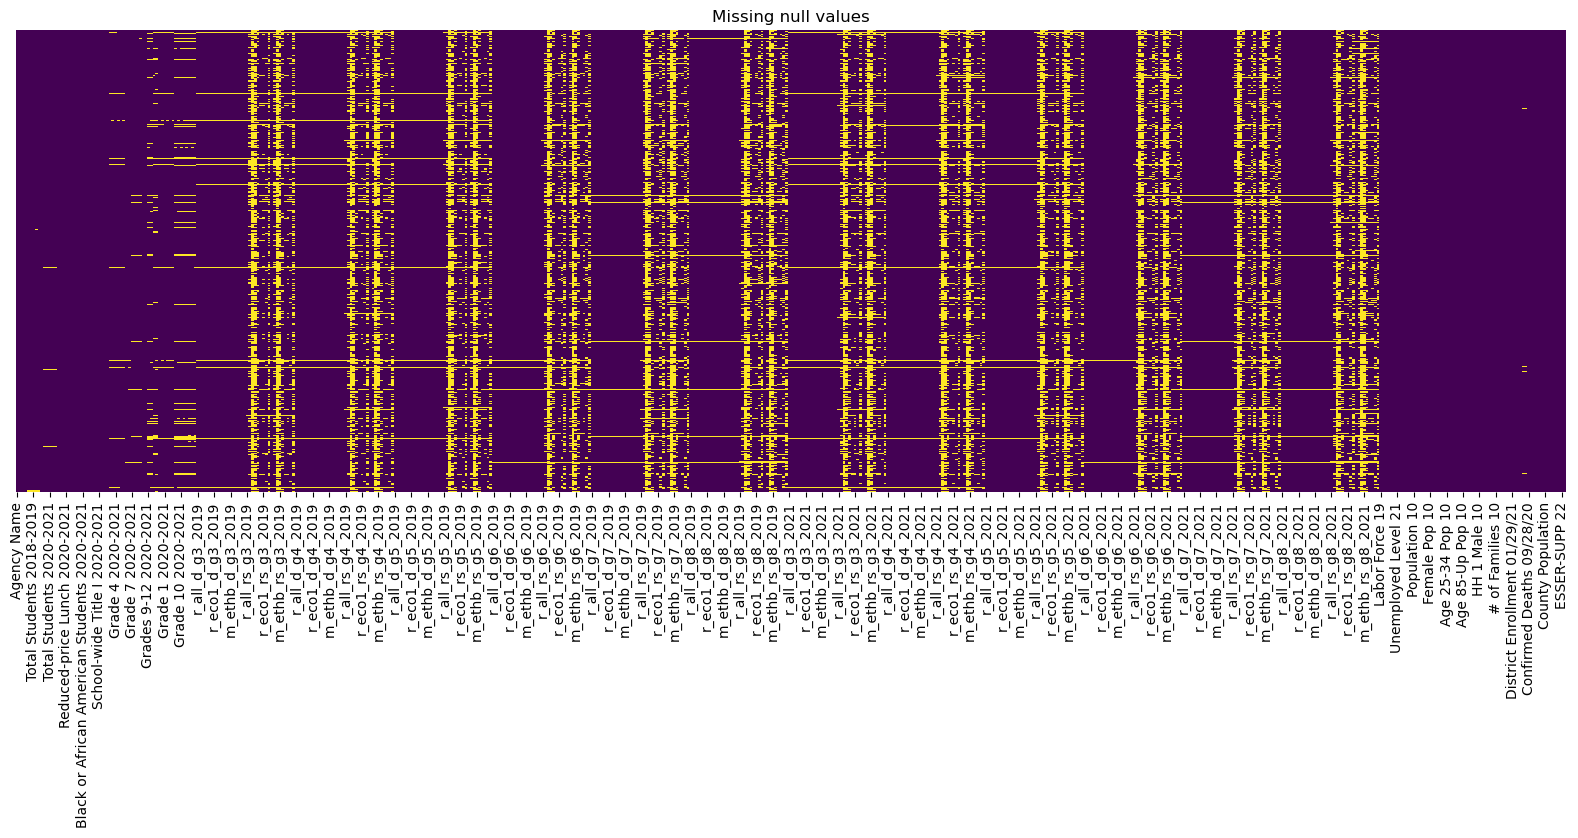

In [43]:
plt.rcParams['figure.figsize'] = (20,6)
sns.heatmap(df_merge.isna(), yticklabels = False, cbar = False , cmap = 'viridis')
plt.title("Missing null values")
plt.show()

In [44]:
df=df_merge.copy()
cols_norm=[]

## Normalization:
Normalizing numberical data into a percentage.

- Total Operational Public Schools
- School-wide Title 1
- Title 1 Eligible School

In [45]:
cols_sch = ['Total Operational Public Schools 2020-2021',
            'Total Operational Public Schools 2018-2019',
            'School-wide Title I 2020-2021',
            'School-wide Title I 2018-2019',
            'Title I Eligible School 2020-2021',
            'Title I Eligible School 2018-2019']

for col in cols_sch:
    if col[-4:] == '2019': 
        df['% '+col] = df[col] / df['Total Public Schools 2018-2019']
        cols_norm.append('% '+col)
    else: 
        df['% '+col] = df[col] / df['Total Public Schools 2020-2021']
        cols_norm.append('% '+col)

- Teachers & Staff: FTE Teachers, Total Staff
- Lunch Program: Free Lunch, Reduced-price Lunch
- Race/Ethnicity: Asian, Hispanic, Black, White
- Grade group(level): Grades 1-8, Grades 9-12, Prekindergarten, Kindergarten 
- Grade (each): Grade 1 to Grade 12
- Average Daily Attendance(ADA)

In [46]:
cols_old = ['FTE Teachers 2020-2021',
            'FTE Teachers 2018-2019',
            'Total Staff 2020-2021',
            'Total Staff 2018-2019',
            'Free Lunch 2020-2021',
            'Free Lunch 2018-2019',
            'Reduced-price Lunch 2020-2021',
            'Reduced-price Lunch 2018-2019',
            'Asian or Asian/Pacific Islander Students 2020-2021',
            'Asian or Asian/Pacific Islander Students 2018-2019',
            'Hispanic Students 2020-2021',
            'Hispanic Students 2018-2019',
            'Black or African American Students 2020-2021',
            'Black or African American Students 2018-2019',
            'White Students 2020-2021',
            'White Students 2018-2019',
            'Grades 1-8 2020-2021',
            'Grades 1-8 2018-2019',
            'Grades 9-12 2020-2021',
            'Grades 9-12 2018-2019',
            'Prek 2020-2021',
            'Prek 2018-2019',
            'K 2020-2021',
            'K 2018-2019',
            'Grade 1 2020-2021',
            'Grade 1 2018-2019',
            'Grade 2 2020-2021',
            'Grade 2 2018-2019',
            'Grade 3 2020-2021',
            'Grade 3 2018-2019',
            'Grade 4 2020-2021',
            'Grade 4 2018-2019',
            'Grade 5 2020-2021',
            'Grade 5 2018-2019',
            'Grade 6 2020-2021',
            'Grade 6 2018-2019',
            'Grade 7 2020-2021',
            'Grade 7 2018-2019',
            'Grade 8 2020-2021',
            'Grade 8 2018-2019',
            'Grade 9 2020-2021',
            'Grade 9 2018-2019',
            'Grade 10 2020-2021',
            'Grade 10 2018-2019',
            'Grade 11 2020-2021',
            'Grade 11 2018-2019',
            'Grade 12 2020-2021',
            'Grade 12 2018-2019',
            '2018-2019 ADA',
            '2020-2021 ADA']

cols_new = ['Teachers:Students 2020-2021',
            'Teachers:Students 2018-2019',
            'Staff:Students 2020-2021',
            'Staff:Students 2018-2019',
            '% Free Lunch 2020-2021',
            '% Free Lunch 2018-2019',
            '% Reduced-price Lunch 2020-2021',
            '% Reduced-price Lunch 2018-2019',
            '% Asian or Asian/Pacific Islander Students 2020-2021',
            '% Asian or Asian/Pacific Islander Students 2018-2019',
            '% Hispanic Students 2020-2021',
            '% Hispanic Students 2018-2019',
            '% Black or African American Students 2020-2021',
            '% Black or African American Students 2018-2019',
            '% White Students 2020-2021',
            '% White Students 2018-2019',
            '% Grades 1-8 2020-2021',
            '% Grades 1-8 2018-2019',
            '% Grades 9-12 2020-2021',
            '% Grades 9-12 2018-2019',
            '% Prek 2020-2021',
            '% Prek 2018-2019',
            '% K 2020-2021',
            '% K 2018-2019',
            '% Grade 1 2020-2021',
            '% Grade 1 2018-2019',
            '% Grade 2 2020-2021',
            '% Grade 2 2018-2019',
            '% Grade 3 2020-2021',
            '% Grade 3 2018-2019',
            '% Grade 4 2020-2021',
            '% Grade 4 2018-2019',
            '% Grade 5 2020-2021',
            '% Grade 5 2018-2019',
            '% Grade 6 2020-2021',
            '% Grade 6 2018-2019',
            '% Grade 7 2020-2021',
            '% Grade 7 2018-2019',
            '% Grade 8 2020-2021',
            '% Grade 8 2018-2019',
            '% Grade 9 2020-2021',
            '% Grade 9 2018-2019',
            '% Grade 10 2020-2021',
            '% Grade 10 2018-2019',
            '% Grade 11 2020-2021',
            '% Grade 11 2018-2019',
            '% Grade 12 2020-2021',
            '% Grade 12 2018-2019',
            '% ADA 2018-2019',
            '% ADA 2020-2021']

for old, new in zip(cols_old, cols_new):
    if old[-4:] == '2019': 
        df[new] = df[old] / df['Total Students 2018-2019']
        cols_norm.append(new)
    else: 
        df[new] = df[old] / df['Total Students 2020-2021']
        cols_norm.append(new)

- Percent of total students that took the STAAR Reading and Math tests per grade

In [47]:
cols_math = ['m_all_d_g3_2019',
            'm_all_d_g4_2019',
            'm_all_d_g5_2019',
            'm_all_d_g6_2019',
            'm_all_d_g7_2019',
            'm_all_d_g8_2019',
            'm_all_d_g3_2021',
            'm_all_d_g4_2021',
            'm_all_d_g5_2021',
            'm_all_d_g6_2021',
            'm_all_d_g7_2021',
            'm_all_d_g8_2021']

cols_reading = ['r_all_d_g3_2019',
            'r_all_d_g4_2019',
            'r_all_d_g5_2019',
            'r_all_d_g6_2019',
            'r_all_d_g7_2019',
            'r_all_d_g8_2019',
            'r_all_d_g3_2021',
            'r_all_d_g4_2021',
            'r_all_d_g5_2021',
            'r_all_d_g6_2021',
            'r_all_d_g7_2021',
            'r_all_d_g8_2021']

cols_grade = ['Grade 3 2018-2019',
            'Grade 4 2018-2019',
            'Grade 5 2018-2019',
            'Grade 6 2018-2019',
            'Grade 7 2018-2019',
            'Grade 8 2018-2019',
            'Grade 3 2020-2021',
            'Grade 4 2020-2021',
            'Grade 5 2020-2021',
            'Grade 6 2020-2021',
            'Grade 7 2020-2021',
            'Grade 8 2020-2021']

for math, reading, grade in zip(cols_math, cols_reading, cols_grade):
    df['% Students Tested Math - ' + grade] = df[[math, grade]].apply(lambda x: np.nan if x[grade]==0
                                                                      else x[math] / x[grade], axis=1)
    df['% Students Tested Reading - ' + grade] = df[[reading, grade]].apply(lambda x: np.nan if x[grade]==0
                                                                      else x[reading] / x[grade], axis=1)
    cols_norm.append('% Students Tested Math - ' + grade)
    cols_norm.append('% Students Tested Reading - ' + grade)

- Average Math and Reading score as a ratio to the 100th percentile score in each grade

In [48]:
cols_math =['m_all_rs',
            'm_ethh_rs',
            'm_etha_rs',
            'm_ethb_rs',
            'm_ethw_rs',
            'm_ecoy_rs',
            'm_eco1_rs',
            'm_ti1y_rs',
            'm_spey_rs']

cols_reading = ['r_all_rs',
                'r_ethh_rs',
                'r_etha_rs',
                'r_ethb_rs',
                'r_ethw_rs',
                'r_ecoy_rs',
                'r_eco1_rs',
                'r_ti1y_rs',
                'r_spey_rs']

cols_group = ['All',
            'Hispanic',
            'Asian',
            'Black',
            'White',
            'Poverty',
            'Free Lunch',
            'T1',
            'Special Ed']

for year in ['2018-2019', '2020-2021']:
    for grade in ['3', '4', '5', '6', '7', '8']:
        max_math = df['m_all_rs_g' + grade + '_' + year[-4:]].quantile(1)
        max_reading = df['r_all_rs_g' + grade + '_' + year[-4:]].quantile(1)     

        for math, reading, group in zip(cols_math, cols_reading, cols_group):
            math_old = math + '_g' + grade + '_' + year[-4:]
            reading_old = reading + '_g' + grade + '_' + year[-4:]
            math_new = 'Average Score Math ' + group + ' Grade ' + grade + ' ' + year
            reading_new = 'Average Score Reading ' + group + ' Grade ' + grade + ' ' + year
#             df[math_new] = df[math_old] / max_math
#             df[reading_new] = df[reading_old] / max_reading
            df[math_new] = df[math_old].apply(lambda x: x/max_math)
            df[reading_new] = df[reading_old].apply(lambda x: x/max_reading)
            cols_norm.append(math_new)
            cols_norm.append(reading_new)

/var/folders/r0/cx28jby50vv14k5xp2yrpdkm0000gn/T/ipykernel_13773/677707571.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[math_new] = df[math_old].apply(lambda x: x/max_math)
/var/folders/r0/cx28jby50vv14k5xp2yrpdkm0000gn/T/ipykernel_13773/677707571.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[reading_new] = df[reading_old].apply(lambda x: x/max_reading)
/var/folders/r0/cx28jby50vv14k5xp2yrpdkm0000gn/T/ipykernel_13773/677707571.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the re

- Average daily attendance as a percent of Total Students per district

In [49]:
df['% ADA 2018-2019'] = df['2018-2019 ADA'] / df['Total Students 2018-2019']
df['% ADA 2020-2021'] = df['2020-2021 ADA'] / df['Total Students 2020-2021']

cols_norm.append('% ADA 2018-2019')
cols_norm.append('% ADA 2020-2021')

- Confirmed Cases and Confirmed Deathes as a percent of County Population.

In [50]:
df['% County Infected 09/28/20'] = df.apply(lambda x: x['Confirmed Cases 09/28/20'] / x['County Population'], axis=1)
df['% County Deaths 09/28/20'] = df.apply(lambda x: x['Confirmed Deaths 09/28/20'] / x['County Population'], axis=1)

df['% County Infected 10/30/20'] = df.apply(lambda x: x['Confirmed Cases 10/30/20'] / x['County Population'], axis=1)
df['% County Deaths 10/30/20'] = df.apply(lambda x: x['Confirmed Deaths 10/30/20'] / x['County Population'], axis=1)

df['% County Infected 01/29/21'] = df.apply(lambda x: x['Confirmed Cases 01/29/21'] / x['County Population'], axis=1)
df['% County Deaths 01/29/21'] = df.apply(lambda x: x['Confirmed Deaths 01/29/21'] / x['County Population'], axis=1)

cols_norm.append('% County Infected 09/28/20')
cols_norm.append('% County Deaths 09/28/20')
cols_norm.append('% County Infected 10/30/20')
cols_norm.append('% County Deaths 10/30/20')
cols_norm.append('% County Infected 01/29/21')
cols_norm.append('% County Deaths 01/29/21')

- Percent of the students on campus for each date 09/28/20, 10/30/20, and 01/29/21.

In [51]:
df['% On Campus 09/28/20'] = df.apply(lambda x: x['Approx. District On-Campus Enrollment 09/28/20'] / x['District Enrollment 09/28/20'], axis=1)
df['% On Campus 10/30/20'] = df.apply(lambda x: x['Approx. District On-Campus Enrollment 10/30/20'] / x['District Enrollment 10/30/20'], axis=1)
df['% On Campus 01/29/21'] = df.apply(lambda x: x['Approx. District On-Campus Enrollment 01/29/21'] / x['District Enrollment 01/29/21'], axis=1)

cols_norm.append('% On Campus 09/28/20')
cols_norm.append('% On Campus 10/30/20')
cols_norm.append('% On Campus 01/29/21')

- Race/Ethnicity and Age groups as a percent of County Population in 2010 (`Population 2010`)

In [52]:
cols_pop = ['White Pop 10',
            'Black Pop 10',
            'Asian Pop 10',
            'Hispanic Pop 10',
            'Male Pop 10',
            'Female Pop 10',
            'Age 0-4 Pop 10',
            'Age 5-9 Pop 10',
            'Age 10-14 Pop 10',
            'Age 15-19 Pop 10',
            'Age 20-24 Pop 10',
            'Age 25-34 Pop 10',
            'Age 35-44 Pop 10',
            'Age 45-54 Pop 10',
            'Age 55-64 Pop 10',
            'Age 65-74 Pop 10',
            'Age 75-84 Pop 10',
            'Age 85-Up Pop 10']

for c in cols_pop:
    df['% '+c] = df.apply(lambda x: x[c] / x['Population 10'], axis=1)
    cols_norm.append('% '+c)

- Number of different types of Households as a percent of Total Number of Households in 2010 (`# of Households 10`)

In [53]:
cols_hh = ['HH 1 Male 10',
            'HH 1 Female 10',
            'HH Married-Child 10',
            'HH Married-noChild 10',
            'HH Male-Child 10',
            'HH Female-Child 10']

for c in cols_hh:
    df['% '+c] = df.apply(lambda x: x[c] / x['# of Households 10'], axis=1)
    cols_norm.append('% '+c)

- Number of different types of Housing Units as a percent of Total Number of Housing Units in 2010 (`# of Housing Units 10`)

In [54]:
cols_house = ['Housing Vacant 10',
            'Housing Owner Occup 10',
            'Housing Renter Occup 10']

for c in cols_house:
    df['% '+c] = df.apply(lambda x: x[c] / x['# of Housing Units 10'], axis=1)
    cols_norm.append('% '+c)

## Calculating Delta: 
Getting differences for the important variables having both values for 2018-2019 and 2020-2021

In [55]:
cols_diff = ['Total Public Schools',
            'Total Students',
            '% Total Operational Public Schools',
            '% School-wide Title I',
            '% Title I Eligible School',
            'Teachers:Students',
            'Staff:Students',
            '% Free Lunch',
            '% Reduced-price Lunch',
            '% Asian or Asian/Pacific Islander Students',
            '% Hispanic Students',
            '% Black or African American Students',
            '% White Students',
            '% Grades 1-8',
            '% Grades 9-12',
            '% Prek',
            '% K',
            '% ADA',
            '% Students Tested Math - Grade 3',
            '% Students Tested Reading - Grade 3',
            '% Students Tested Math - Grade 4',
            '% Students Tested Reading - Grade 4',
            '% Students Tested Math - Grade 5',
            '% Students Tested Reading - Grade 5',
            '% Students Tested Math - Grade 6',
            '% Students Tested Reading - Grade 6',
            '% Students Tested Math - Grade 7',
            '% Students Tested Reading - Grade 7',
            '% Students Tested Math - Grade 8',
            '% Students Tested Reading - Grade 8',
            '% Grade 1',
            '% Grade 2',
            '% Grade 3',
            '% Grade 4',
            '% Grade 5',
            '% Grade 6',
            '% Grade 7',
            '% Grade 8',
            '% Grade 9',
            '% Grade 10',
            '% Grade 11',
            '% Grade 12']

In [56]:
for var in cols_diff:
    df[var + ' Diff'] = df.apply(lambda x: 0 if x[[var + ' 2018-2019', var + ' 2020-2021']].sum() == 0
                                 else np.nan if x[var + ' 2018-2019'] == 0 
                                 else np.nan if x[[var + ' 2018-2019', var + ' 2020-2021']].isna().any()
                                 else (x[var + ' 2020-2021'] - x[var + ' 2018-2019']) / x[var + ' 2018-2019'], axis=1)

## Labeling ##   
Creating 3 classes for Learning Loss  
- Step 1: Learning Loss is calculated by averaging Average Score of all grades for Math and Reading separately and substracting the 2021 average from 2019 average.

In [57]:
cols_math_2019 = ['Average Score Math All Grade 3 2018-2019',
                'Average Score Math All Grade 4 2018-2019',
                'Average Score Math All Grade 5 2018-2019',
                'Average Score Math All Grade 6 2018-2019',
                'Average Score Math All Grade 7 2018-2019',
                'Average Score Math All Grade 8 2018-2019']

cols_reading_2019 = ['Average Score Reading All Grade 3 2018-2019',
                'Average Score Reading All Grade 4 2018-2019',
                'Average Score Reading All Grade 5 2018-2019',
                'Average Score Reading All Grade 6 2018-2019',
                'Average Score Reading All Grade 7 2018-2019',
                'Average Score Reading All Grade 8 2018-2019']

cols_math_2021 = ['Average Score Math All Grade 3 2020-2021',
                'Average Score Math All Grade 4 2020-2021',
                'Average Score Math All Grade 5 2020-2021',
                'Average Score Math All Grade 6 2020-2021',
                'Average Score Math All Grade 7 2020-2021',
                'Average Score Math All Grade 8 2020-2021']

cols_reading_2021 = ['Average Score Reading All Grade 3 2020-2021',
                'Average Score Reading All Grade 4 2020-2021',
                'Average Score Reading All Grade 5 2020-2021',
                'Average Score Reading All Grade 6 2020-2021',
                'Average Score Reading All Grade 7 2020-2021',
                'Average Score Reading All Grade 8 2020-2021']

df['AVG_Math_2019'] = df[cols_math_2019].apply(lambda x: x.sum() / len(cols_math_2019), axis=1)
df['AVG_Reading_2019'] = df[cols_reading_2019].apply(lambda x: x.sum() / len(cols_reading_2019), axis=1)
df['AVG_Math_2021'] = df[cols_math_2021].apply(lambda x: x.sum() / len(cols_math_2021), axis=1)
df['AVG_Reading_2021'] = df[cols_reading_2021].apply(lambda x: x.sum() / len(cols_reading_2021), axis=1)

Get Percent Loss Different from 2019 to 2021 for the perspective of 2019. % LOSS = (AVG 2021 - AVG 2019)/AVG 2019

if '% Loss' Difference > 0, 2021 Learning is better than 2019, that is there is Learning Gain   
if '% Loss' Difference < 0, 2021 Learning is worse than 2019, that is there is Learning Loss

In [58]:
df['% LOSS Math'] = (df['AVG_Math_2021'] - df['AVG_Math_2019']) / df['AVG_Math_2019']
df['% LOSS Reading'] = (df['AVG_Reading_2021'] - df['AVG_Reading_2019']) / df['AVG_Reading_2019']
df['% LOSS All'] = df[['% LOSS Math', '% LOSS Reading']].apply(lambda x: x.mean(), axis=1)

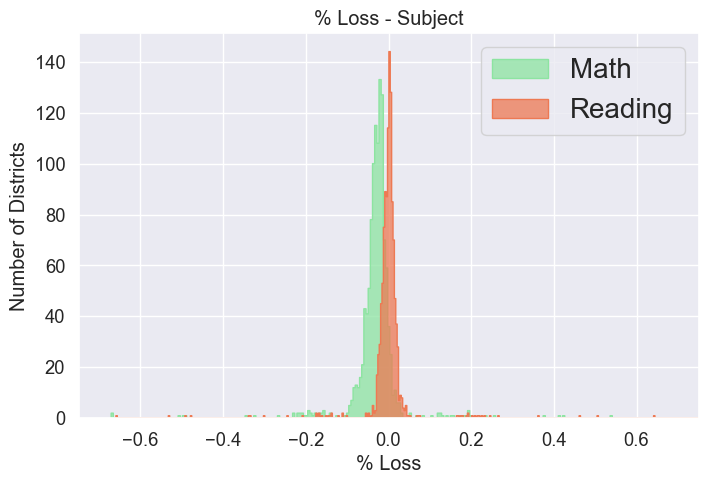

In [59]:
sns.set(rc={'figure.figsize':(8,5)})
sns.set(font_scale=1.2)

g = sns.histplot(data=df, x='% LOSS Math', shrink=0.8, color='#8de4a1', label='Math', element="step", stat="count")
g = sns.histplot(data=df, x='% LOSS Reading', shrink=0.8, color='#ed7953', label='Reading', element="step", stat="count")
g.set(xlabel='% Loss', ylabel='Number of Districts', title='% Loss - Subject')
g.set_xlim(-.75, .75)
plt.legend(loc='upper right', fontsize=20)
plt.show()

In [60]:
cols = ['% LOSS Math', '% LOSS Reading', '% LOSS All']
df[cols].describe()

,% LOSS Math,% LOSS Reading,% LOSS All
count,1176.000000,1176.000000,1176.000000
mean,-0.027795,0.003030,-0.012382
std,0.093129,0.090525,0.090853
min,-0.671508,-0.659782,-0.665645
25%,-0.042456,-0.008950,-0.025117
50%,-0.027013,0.001024,-0.013329
75%,-0.014829,0.008671,-0.003449
max,1.904820,1.981681,1.943251


- Step 2: Decide threshold for labelings using `% LOSS Math` and `% LOSS Reading` separately.
    - 0 ***(Expected)***:  25th percentile <= x <= 75th percentile
    - 1 ***(Gain)***: 75th percentile < x
    - -1 ***(Loss)***:  x < 25th percentile

In [61]:
mean_math = df['% LOSS Math'].mean()
std_math = df['% LOSS Math'].std()
q_25_math = df['% LOSS Math'].quantile(0.25)
q_75_math = df['% LOSS Math'].quantile(0.75)

mean_reading = df['% LOSS Reading'].mean()
std_reading = df['% LOSS Reading'].std()
q_25_reading = df['% LOSS Reading'].quantile(0.25)
q_75_reading = df['% LOSS Reading'].quantile(0.75)

mean_all = df['% LOSS All'].mean()
std_all = df['% LOSS All'].std()
q_25_all = df['% LOSS All'].quantile(0.25)
q_75_all = df['% LOSS All'].quantile(0.75)

sig = 1
sig_pos_math = mean_math + (sig * std_math)
sig_neg_math = mean_math - (sig * std_math)
sig_pos_reading = mean_reading + (sig * std_reading)
sig_neg_reading = mean_reading - (sig * std_reading)
sig_pos_all = mean_all + (sig * std_all)
sig_neg_all = mean_all - (sig * std_all)

df['Label_Math'] = df['% LOSS Math'].apply(lambda x: 0 if ((x >= q_25_math) & (x <= q_75_math))
                                   else 1 if (x > q_75_math)
                                   else -1 if (x < q_25_math)
                                   else -100)   

df['Label_Reading'] = df['% LOSS Reading'].apply(lambda x: 0 if ((x >= q_25_reading) & (x <= q_75_reading))
                                   else 1 if (x > q_75_reading)
                                   else -1 if (x < q_25_reading)
                                   else -100)    

df['Label_All'] = df['% LOSS All'].apply(lambda x: 0 if ((x >= q_25_all) & (x <= q_75_all))
                                   else 1 if (x > q_75_all)
                                   else -1 if (x < q_25_all)
                                   else -100)      

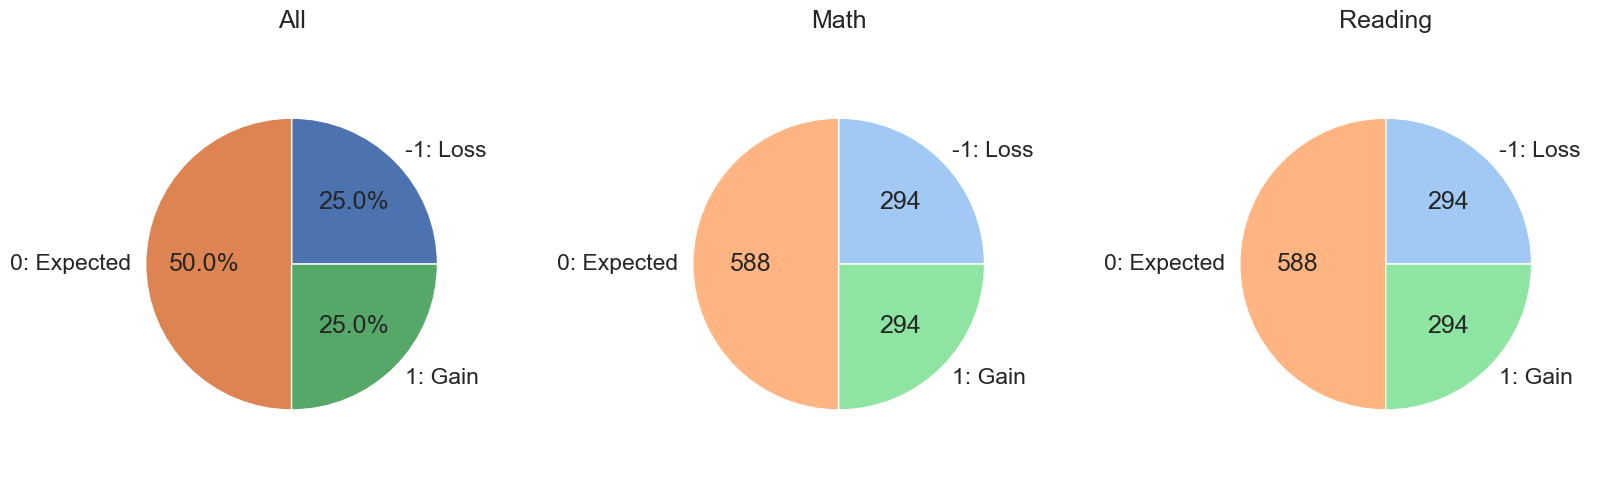

In [62]:
df_math = df['Label_Math'].value_counts().sort_index().to_frame()
df_math.reset_index(inplace=True)
df_math['label'] = df_math['index'].apply(lambda x: '-1: Loss' if x == -1
                                         else '0: Expected' if x == 0
                                         else '1: Gain' if x == 1
                                         else '-100')

df_reading = df['Label_Reading'].value_counts().sort_index().to_frame()
df_reading.reset_index(inplace=True)
df_reading['label'] = df_reading['index'].apply(lambda x: '-1: Loss' if x == -1
                                         else '0: Expected' if x == 0
                                         else '1: Gain' if x == 1
                                         else '-100')

df_all = df['Label_All'].value_counts().sort_index().to_frame()
df_all.reset_index(inplace=True)
df_all['label'] = df_all['index'].apply(lambda x: '-1: Loss' if x == -1
                                         else '0: Expected' if x == 0
                                         else '1: Gain' if x == 1
                                         else '-100')

fig, axes=plt.subplots(1,3, figsize=(20,10))
sns.set(font_scale=1.5)

colors=sns.color_palette('deep')[:df_all.shape[0]]
axes[0].pie(df_all['Label_All'], labels=df_all['label'], colors=colors, autopct='%1.1f%%', radius=.8)
axes[0].set(title='All')

colors=sns.color_palette('pastel')[:df_math.shape[0]]
axes[1].pie(df_math['Label_Math'], labels=df_math['label'], colors=colors, radius=.8,
            autopct=lambda p: '{:.0f}'.format(p*df_all['Label_All'].sum()/100))
axes[1].set(title='Math')

colors=sns.color_palette('pastel')[:df_reading.shape[0]]
axes[2].pie(df_reading['Label_Reading'], labels=df_reading['label'], colors=colors, radius=.8,
            autopct=lambda p: '{:.0f}'.format(p*df_all['Label_All'].sum()/100))
axes[2].set(title='Reading')

plt.show()

## Data Cleaning for ML Modeling ##  
Dropping instances with missing values or redundant columns that are normalized.

In [63]:
cols_keep = ['Locale',
'Labor Force Diff',
'Employed Diff',
'Unemployed Level Diff',
'Unemployed Rate Diff',
'Median Age 10',
'Median Age Male 10',
'Median Age Female 10',
'# of Households 10',
'Avg Household Size 10',
'# of Families 10',
'Avg Family Size 10',
'# of Housing Units 10',
'County Population',
'CARES ESSER I 20',
'CRRSA ESSER II 21',
'ARP ESSER III 21',
'ESSER-SUPP 22',
'ESSER-SUPP 23',
'% County Infected 09/28/20',
'% County Deaths 09/28/20',
'% County Infected 10/30/20',
'% County Deaths 10/30/20',
'% County Infected 01/29/21',
'% County Deaths 01/29/21',
'% On Campus 09/28/20',
'% On Campus 10/30/20',
'% On Campus 01/29/21',
'% White Pop 10',
'% Black Pop 10',
'% Asian Pop 10',
'% Hispanic Pop 10',
'% Male Pop 10',
'% Female Pop 10',
'% Age 0-4 Pop 10',
'% Age 5-9 Pop 10',
'% Age 10-14 Pop 10',
'% Age 15-19 Pop 10',
'% Age 20-24 Pop 10',
'% Age 25-34 Pop 10',
'% Age 35-44 Pop 10',
'% Age 45-54 Pop 10',
'% Age 55-64 Pop 10',
'% Age 65-74 Pop 10',
'% Age 75-84 Pop 10',
'% Age 85-Up Pop 10',
'% HH 1 Male 10',
'% HH 1 Female 10',
'% HH Married-Child 10',
'% HH Married-noChild 10',
'% HH Male-Child 10',
'% HH Female-Child 10',
'% Housing Vacant 10',
'% Housing Owner Occup 10',
'% Housing Renter Occup 10',
'Total Public Schools Diff',
'Total Students Diff',
'% Total Operational Public Schools Diff',
'% School-wide Title I Diff',
'% Title I Eligible School Diff',
'Teachers:Students Diff',
'Staff:Students Diff',
'% Free Lunch Diff',
'% Reduced-price Lunch Diff',
'% Asian or Asian/Pacific Islander Students Diff',
'% Hispanic Students Diff',
'% Black or African American Students Diff',
'% White Students Diff',
'% Grades 1-8 Diff',
'% Grades 9-12 Diff',
'% Prek Diff',
'% K Diff',
'% ADA Diff',
'% Students Tested Math - Grade 3 Diff',
'% Students Tested Reading - Grade 3 Diff',
'% Students Tested Math - Grade 4 Diff',
'% Students Tested Reading - Grade 4 Diff',
'% Students Tested Math - Grade 5 Diff',
'% Students Tested Reading - Grade 5 Diff',
'% Students Tested Math - Grade 6 Diff',
'% Students Tested Reading - Grade 6 Diff',
'% Students Tested Math - Grade 7 Diff',
'% Students Tested Reading - Grade 7 Diff',
'% Students Tested Math - Grade 8 Diff',
'% Students Tested Reading - Grade 8 Diff',
'Label_Math',
'Label_Reading',
'Label_All']

cols_new = ['Locale',
'Labor Force Diff',
'Employed Diff',
'Unemployed Level Diff',
'Unemployed Rate Diff',
'Median Age 10',
'Median Age Male 10',
'Median Age Female 10',
'# of Households 10',
'Avg Household Size 10',
'# of Families 10',
'Avg Family Size 10',
'# of Housing Units 10',
'County Population',
'CARES ESSER I 20',
'CRRSA ESSER II 21',
'ARP ESSER III 21',
'ESSER-SUPP 22',
'ESSER-SUPP 23',
'% County Infected 09/28/20',
'% County Deaths 09/28/20',
'% County Infected 10/30/20',
'% County Deaths 10/30/20',
'% County Infected 01/29/21',
'% County Deaths 01/29/21',
'% On Campus 09/28/20',
'% On Campus 10/30/20',
'% On Campus 01/29/21',
'% White Pop 10',
'% Black Pop 10',
'% Asian Pop 10',
'% Hispanic Pop 10',
'% Male Pop 10',
'% Female Pop 10',
'% Age 0-4 Pop 10',
'% Age 5-9 Pop 10',
'% Age 10-14 Pop 10',
'% Age 15-19 Pop 10',
'% Age 20-24 Pop 10',
'% Age 25-34 Pop 10',
'% Age 35-44 Pop 10',
'% Age 45-54 Pop 10',
'% Age 55-64 Pop 10',
'% Age 65-74 Pop 10',
'% Age 75-84 Pop 10',
'% Age 85-Up Pop 10',
'% HH 1 Male 10',
'% HH 1 Female 10',
'% HH Married-Child 10',
'% HH Married-noChild 10',
'% HH Male-Child 10',
'% HH Female-Child 10',
'% Housing Vacant 10',
'% Housing Owner Occup 10',
'% Housing Renter Occup 10',
'Total Schools Diff',
'Total Students Diff',
'% Operational Schools Diff',
'% Title 1 School-wide Diff',
'% Title 1 Eligible Diff',
'Teachers:Students Diff',
'Staff:Students Diff',
'% Free Lunch Diff',
'% Reduced-price Lunch Diff',
'% Asian Diff',
'% Hispanic Diff',
'% Black Diff',
'% White Diff',
'% Grades 1-8 Diff',
'% Grades 9-12 Diff',
'% Prek Diff',
'% Kinder Diff',
'% ADA Diff',
'% Tested Math G3 Diff',
'% Tested Reading G3 Diff',
'% Tested Math G4 Diff',
'% Tested Reading G4 Diff',
'% Tested Math G5 Diff',
'% Tested Reading G5 Diff',
'% Tested Math G6 Diff',
'% Tested Reading G6 Diff',
'% Tested Math G7 Diff',
'% Tested Reading G7 Diff',
'% Tested Math G8 Diff',
'% Tested Reading G8 Diff',
'Label_Math',
'Label_Reading',
'Label_All']

print(len(cols_keep), len(cols_new))

88 88


In [64]:
print('Shape:', df.shape)
temp=[c + ': ' + str(df[c].isna().sum()) for c in df[cols_keep] if df[c].isna().any()]
temp

Shape: (1176, 950)


['% On Campus 09/28/20: 5',
 'Total Public Schools Diff: 8',
 'Total Students Diff: 8',
 '% Total Operational Public Schools Diff: 8',
 '% School-wide Title I Diff: 18',
 '% Title I Eligible School Diff: 15',
 'Teachers:Students Diff: 9',
 'Staff:Students Diff: 8',
 '% Free Lunch Diff: 11',
 '% Reduced-price Lunch Diff: 92',
 '% Asian or Asian/Pacific Islander Students Diff: 54',
 '% Hispanic Students Diff: 8',
 '% Black or African American Students Diff: 41',
 '% White Students Diff: 11',
 '% Grades 1-8 Diff: 8',
 '% Grades 9-12 Diff: 17',
 '% Prek Diff: 19',
 '% K Diff: 11',
 '% ADA Diff: 8',
 '% Students Tested Math - Grade 3 Diff: 3',
 '% Students Tested Reading - Grade 3 Diff: 3',
 '% Students Tested Math - Grade 4 Diff: 4',
 '% Students Tested Reading - Grade 4 Diff: 4',
 '% Students Tested Math - Grade 5 Diff: 4',
 '% Students Tested Reading - Grade 5 Diff: 4',
 '% Students Tested Math - Grade 6 Diff: 6',
 '% Students Tested Reading - Grade 6 Diff: 6',
 '% Students Tested Math -

In [65]:
cols_v4=['County #',
'Total Operational Public Schools 2018-2019',
'Total Public Schools 2018-2019',
'Total Students 2018-2019',
'FTE Teachers 2018-2019',
'Total Staff 2018-2019',
'District #',
'Total Operational Public Schools 2020-2021',
'Total Public Schools 2020-2021',
'Total Students 2020-2021',
'FTE Teachers 2020-2021',
'Total Staff 2020-2021',
'Locale',
'Free Lunch 2020-2021',
'Free Lunch 2018-2019',
'Reduced-price Lunch 2020-2021',
'Reduced-price Lunch 2018-2019',
'Asian or Asian/Pacific Islander Students 2020-2021',
'Asian or Asian/Pacific Islander Students 2018-2019',
'Hispanic Students 2020-2021',
'Hispanic Students 2018-2019',
'Black or African American Students 2020-2021',
'Black or African American Students 2018-2019',
'White Students 2020-2021',
'White Students 2018-2019',
'School-wide Title I 2020-2021',
'School-wide Title I 2018-2019',
'Title I Eligible School 2020-2021',
'Title I Eligible School 2018-2019',
'Grade 3 2020-2021',
'Grade 3 2018-2019',
'Grade 4 2020-2021',
'Grade 4 2018-2019',
'Grade 5 2020-2021',
'Grade 5 2018-2019',
'Grade 6 2020-2021',
'Grade 6 2018-2019',
'Grade 7 2020-2021',
'Grade 7 2018-2019',
'Grade 8 2020-2021',
'Grade 8 2018-2019',
'Prek 2020-2021',
'Prek 2018-2019',
'K 2020-2021',
'K 2018-2019',
'Grade 1 2020-2021',
'Grade 1 2018-2019',
'Grade 2 2020-2021',
'Grade 2 2018-2019',
'Grade 9 2020-2021',
'Grade 9 2018-2019',
'Grade 10 2020-2021',
'Grade 10 2018-2019',
'Grade 11 2020-2021',
'Grade 11 2018-2019',
'Grade 12 2020-2021',
'Grade 12 2018-2019',
'r_all_d_g3_2019',
'r_ethh_d_g3_2019',
'r_etha_d_g3_2019',
'r_ethb_d_g3_2019',
'r_ethw_d_g3_2019',
'r_ecoy_d_g3_2019',
'r_eco1_d_g3_2019',
'r_ti1y_d_g3_2019',
'r_spey_d_g3_2019',
'm_all_d_g3_2019',
'm_ethh_d_g3_2019',
'm_etha_d_g3_2019',
'm_ethb_d_g3_2019',
'm_ethw_d_g3_2019',
'm_ecoy_d_g3_2019',
'm_eco1_d_g3_2019',
'm_ti1y_d_g3_2019',
'm_spey_d_g3_2019',
'r_all_d_g4_2019',
'r_ethh_d_g4_2019',
'r_etha_d_g4_2019',
'r_ethb_d_g4_2019',
'r_ethw_d_g4_2019',
'r_ecoy_d_g4_2019',
'r_eco1_d_g4_2019',
'r_ti1y_d_g4_2019',
'r_spey_d_g4_2019',
'm_all_d_g4_2019',
'm_ethh_d_g4_2019',
'm_etha_d_g4_2019',
'm_ethb_d_g4_2019',
'm_ethw_d_g4_2019',
'm_ecoy_d_g4_2019',
'm_eco1_d_g4_2019',
'm_ti1y_d_g4_2019',
'm_spey_d_g4_2019',
'r_all_d_g5_2019',
'r_ethh_d_g5_2019',
'r_etha_d_g5_2019',
'r_ethb_d_g5_2019',
'r_ethw_d_g5_2019',
'r_ecoy_d_g5_2019',
'r_eco1_d_g5_2019',
'r_ti1y_d_g5_2019',
'r_spey_d_g5_2019',
'm_all_d_g5_2019',
'm_ethh_d_g5_2019',
'm_etha_d_g5_2019',
'm_ethb_d_g5_2019',
'm_ethw_d_g5_2019',
'm_ecoy_d_g5_2019',
'm_eco1_d_g5_2019',
'm_ti1y_d_g5_2019',
'm_spey_d_g5_2019',
'r_all_d_g6_2019',
'r_ethh_d_g6_2019',
'r_etha_d_g6_2019',
'r_ethb_d_g6_2019',
'r_ethw_d_g6_2019',
'r_ecoy_d_g6_2019',
'r_eco1_d_g6_2019',
'r_ti1y_d_g6_2019',
'r_spey_d_g6_2019',
'm_all_d_g6_2019',
'm_ethh_d_g6_2019',
'm_etha_d_g6_2019',
'm_ethb_d_g6_2019',
'm_ethw_d_g6_2019',
'm_ecoy_d_g6_2019',
'm_eco1_d_g6_2019',
'm_ti1y_d_g6_2019',
'm_spey_d_g6_2019',
'r_all_d_g7_2019',
'r_ethh_d_g7_2019',
'r_etha_d_g7_2019',
'r_ethb_d_g7_2019',
'r_ethw_d_g7_2019',
'r_ecoy_d_g7_2019',
'r_eco1_d_g7_2019',
'r_ti1y_d_g7_2019',
'r_spey_d_g7_2019',
'm_all_d_g7_2019',
'm_ethh_d_g7_2019',
'm_etha_d_g7_2019',
'm_ethb_d_g7_2019',
'm_ethw_d_g7_2019',
'm_ecoy_d_g7_2019',
'm_eco1_d_g7_2019',
'm_ti1y_d_g7_2019',
'm_spey_d_g7_2019',
'r_all_d_g8_2019',
'r_ethh_d_g8_2019',
'r_etha_d_g8_2019',
'r_ethb_d_g8_2019',
'r_ethw_d_g8_2019',
'r_ecoy_d_g8_2019',
'r_eco1_d_g8_2019',
'r_ti1y_d_g8_2019',
'r_spey_d_g8_2019',
'm_all_d_g8_2019',
'm_ethh_d_g8_2019',
'm_etha_d_g8_2019',
'm_ethb_d_g8_2019',
'm_ethw_d_g8_2019',
'm_ecoy_d_g8_2019',
'm_eco1_d_g8_2019',
'm_ti1y_d_g8_2019',
'm_spey_d_g8_2019',
'r_all_d_g3_2021',
'r_ethh_d_g3_2021',
'r_etha_d_g3_2021',
'r_ethb_d_g3_2021',
'r_ethw_d_g3_2021',
'r_ecoy_d_g3_2021',
'r_eco1_d_g3_2021',
'r_ti1y_d_g3_2021',
'r_spey_d_g3_2021',
'm_all_d_g3_2021',
'm_ethh_d_g3_2021',
'm_etha_d_g3_2021',
'm_ethb_d_g3_2021',
'm_ethw_d_g3_2021',
'm_ecoy_d_g3_2021',
'm_eco1_d_g3_2021',
'm_ti1y_d_g3_2021',
'm_spey_d_g3_2021',
'r_all_d_g4_2021',
'r_ethh_d_g4_2021',
'r_etha_d_g4_2021',
'r_ethb_d_g4_2021',
'r_ethw_d_g4_2021',
'r_ecoy_d_g4_2021',
'r_eco1_d_g4_2021',
'r_ti1y_d_g4_2021',
'r_spey_d_g4_2021',
'm_all_d_g4_2021',
'm_ethh_d_g4_2021',
'm_etha_d_g4_2021',
'm_ethb_d_g4_2021',
'm_ethw_d_g4_2021',
'm_ecoy_d_g4_2021',
'm_eco1_d_g4_2021',
'm_ti1y_d_g4_2021',
'm_spey_d_g4_2021',
'r_all_d_g5_2021',
'r_ethh_d_g5_2021',
'r_etha_d_g5_2021',
'r_ethb_d_g5_2021',
'r_ethw_d_g5_2021',
'r_ecoy_d_g5_2021',
'r_eco1_d_g5_2021',
'r_ti1y_d_g5_2021',
'r_spey_d_g5_2021',
'm_all_d_g5_2021',
'm_ethh_d_g5_2021',
'm_etha_d_g5_2021',
'm_ethb_d_g5_2021',
'm_ethw_d_g5_2021',
'm_ecoy_d_g5_2021',
'm_eco1_d_g5_2021',
'm_ti1y_d_g5_2021',
'm_spey_d_g5_2021',
'r_all_d_g6_2021',
'r_ethh_d_g6_2021',
'r_etha_d_g6_2021',
'r_ethb_d_g6_2021',
'r_ethw_d_g6_2021',
'r_ecoy_d_g6_2021',
'r_eco1_d_g6_2021',
'r_ti1y_d_g6_2021',
'r_spey_d_g6_2021',
'm_all_d_g6_2021',
'm_ethh_d_g6_2021',
'm_etha_d_g6_2021',
'm_ethb_d_g6_2021',
'm_ethw_d_g6_2021',
'm_ecoy_d_g6_2021',
'm_eco1_d_g6_2021',
'm_ti1y_d_g6_2021',
'm_spey_d_g6_2021',
'r_all_d_g7_2021',
'r_ethh_d_g7_2021',
'r_etha_d_g7_2021',
'r_ethb_d_g7_2021',
'r_ethw_d_g7_2021',
'r_ecoy_d_g7_2021',
'r_eco1_d_g7_2021',
'r_ti1y_d_g7_2021',
'r_spey_d_g7_2021',
'm_all_d_g7_2021',
'm_ethh_d_g7_2021',
'm_etha_d_g7_2021',
'm_ethb_d_g7_2021',
'm_ethw_d_g7_2021',
'm_ecoy_d_g7_2021',
'm_eco1_d_g7_2021',
'm_ti1y_d_g7_2021',
'm_spey_d_g7_2021',
'r_all_d_g8_2021',
'r_ethh_d_g8_2021',
'r_etha_d_g8_2021',
'r_ethb_d_g8_2021',
'r_ethw_d_g8_2021',
'r_ecoy_d_g8_2021',
'r_eco1_d_g8_2021',
'r_ti1y_d_g8_2021',
'r_spey_d_g8_2021',
'm_all_d_g8_2021',
'm_ethh_d_g8_2021',
'm_etha_d_g8_2021',
'm_ethb_d_g8_2021',
'm_ethw_d_g8_2021',
'm_ecoy_d_g8_2021',
'm_eco1_d_g8_2021',
'm_ti1y_d_g8_2021',
'm_spey_d_g8_2021',
'Labor Force 19',
'Employed 19',
'Unemployed Level 19',
'Unemployed Rate 19',
'Labor Force 21',
'Employed 21',
'Unemployed Level 21',
'Unemployed Rate 21',
'White Pop 10',
'Black Pop 10',
'Asian Pop 10',
'Hispanic Pop 10',
'Male Pop 10',
'Female Pop 10',
'Age 0-4 Pop 10',
'Age 5-9 Pop 10',
'Age 10-14 Pop 10',
'Age 15-19 Pop 10',
'Age 20-24 Pop 10',
'Age 25-34 Pop 10',
'Age 35-44 Pop 10',
'Age 45-54 Pop 10',
'Age 55-64 Pop 10',
'Age 65-74 Pop 10',
'Age 75-84 Pop 10',
'Age 85-Up Pop 10',
'Median Age 10',
'Median Age Male 10',
'Median Age Female 10',
'# of Households 10',
'Avg Household Size 10',
'HH 1 Male 10',
'HH 1 Female 10',
'HH Married-Child 10',
'HH Married-noChild 10',
'HH Male-Child 10',
'HH Female-Child 10',
'# of Families 10',
'Avg Family Size 10',
'# of Housing Units 10',
'Housing Vacant 10',
'Housing Owner Occup 10',
'Housing Renter Occup 10',
'District Enrollment 01/29/21',
'Approx. District On-Campus Enrollment 01/29/21',
'District Enrollment 10/30/20',
'Approx. District On-Campus Enrollment 10/30/20',
'District Enrollment 09/28/20',
'Approx. District On-Campus Enrollment 09/28/20',
'Confirmed Deaths 09/28/20',
'Confirmed Deaths 10/30/20',
'Confirmed Deaths 01/29/21',
'Confirmed Cases 09/28/20',
'Confirmed Cases 10/30/20',
'Confirmed Cases 01/29/21',
'County Population',
'2018-2019 ADA',
'2020-2021 ADA',
'CARES ESSER I 20',
'CRRSA ESSER II 21',
'ARP ESSER III 21',
'ESSER-SUPP 22',
'ESSER-SUPP 23',
'Average Score Math Hispanic Grade 3 2018-2019',
'Average Score Reading Hispanic Grade 3 2018-2019',
'Average Score Math Asian Grade 3 2018-2019',
'Average Score Reading Asian Grade 3 2018-2019',
'Average Score Math Black Grade 3 2018-2019',
'Average Score Reading Black Grade 3 2018-2019',
'Average Score Math White Grade 3 2018-2019',
'Average Score Reading White Grade 3 2018-2019',
'Average Score Math Poverty Grade 3 2018-2019',
'Average Score Reading Poverty Grade 3 2018-2019',
'Average Score Math Free Lunch Grade 3 2018-2019',
'Average Score Reading Free Lunch Grade 3 2018-2019',
'Average Score Math T1 Grade 3 2018-2019',
'Average Score Reading T1 Grade 3 2018-2019',
'Average Score Math Special Ed Grade 3 2018-2019',
'Average Score Reading Special Ed Grade 3 2018-2019',
'Average Score Math Hispanic Grade 4 2018-2019',
'Average Score Reading Hispanic Grade 4 2018-2019',
'Average Score Math Asian Grade 4 2018-2019',
'Average Score Reading Asian Grade 4 2018-2019',
'Average Score Math Black Grade 4 2018-2019',
'Average Score Reading Black Grade 4 2018-2019',
'Average Score Math White Grade 4 2018-2019',
'Average Score Reading White Grade 4 2018-2019',
'Average Score Math Poverty Grade 4 2018-2019',
'Average Score Reading Poverty Grade 4 2018-2019',
'Average Score Math Free Lunch Grade 4 2018-2019',
'Average Score Reading Free Lunch Grade 4 2018-2019',
'Average Score Math T1 Grade 4 2018-2019',
'Average Score Reading T1 Grade 4 2018-2019',
'Average Score Math Special Ed Grade 4 2018-2019',
'Average Score Reading Special Ed Grade 4 2018-2019',
'Average Score Math Hispanic Grade 5 2018-2019',
'Average Score Reading Hispanic Grade 5 2018-2019',
'Average Score Math Asian Grade 5 2018-2019',
'Average Score Reading Asian Grade 5 2018-2019',
'Average Score Math Black Grade 5 2018-2019',
'Average Score Reading Black Grade 5 2018-2019',
'Average Score Math White Grade 5 2018-2019',
'Average Score Reading White Grade 5 2018-2019',
'Average Score Math Poverty Grade 5 2018-2019',
'Average Score Reading Poverty Grade 5 2018-2019',
'Average Score Math Free Lunch Grade 5 2018-2019',
'Average Score Reading Free Lunch Grade 5 2018-2019',
'Average Score Math T1 Grade 5 2018-2019',
'Average Score Reading T1 Grade 5 2018-2019',
'Average Score Math Special Ed Grade 5 2018-2019',
'Average Score Reading Special Ed Grade 5 2018-2019',
'Average Score Math Hispanic Grade 6 2018-2019',
'Average Score Reading Hispanic Grade 6 2018-2019',
'Average Score Math Asian Grade 6 2018-2019',
'Average Score Reading Asian Grade 6 2018-2019',
'Average Score Math Black Grade 6 2018-2019',
'Average Score Reading Black Grade 6 2018-2019',
'Average Score Math White Grade 6 2018-2019',
'Average Score Reading White Grade 6 2018-2019',
'Average Score Math Poverty Grade 6 2018-2019',
'Average Score Reading Poverty Grade 6 2018-2019',
'Average Score Math Free Lunch Grade 6 2018-2019',
'Average Score Reading Free Lunch Grade 6 2018-2019',
'Average Score Math T1 Grade 6 2018-2019',
'Average Score Reading T1 Grade 6 2018-2019',
'Average Score Math Special Ed Grade 6 2018-2019',
'Average Score Reading Special Ed Grade 6 2018-2019',
'Average Score Math Hispanic Grade 7 2018-2019',
'Average Score Reading Hispanic Grade 7 2018-2019',
'Average Score Math Asian Grade 7 2018-2019',
'Average Score Reading Asian Grade 7 2018-2019',
'Average Score Math Black Grade 7 2018-2019',
'Average Score Reading Black Grade 7 2018-2019',
'Average Score Math White Grade 7 2018-2019',
'Average Score Reading White Grade 7 2018-2019',
'Average Score Math Poverty Grade 7 2018-2019',
'Average Score Reading Poverty Grade 7 2018-2019',
'Average Score Math Free Lunch Grade 7 2018-2019',
'Average Score Reading Free Lunch Grade 7 2018-2019',
'Average Score Math T1 Grade 7 2018-2019',
'Average Score Reading T1 Grade 7 2018-2019',
'Average Score Math Special Ed Grade 7 2018-2019',
'Average Score Reading Special Ed Grade 7 2018-2019',
'Average Score Math Hispanic Grade 8 2018-2019',
'Average Score Reading Hispanic Grade 8 2018-2019',
'Average Score Math Asian Grade 8 2018-2019',
'Average Score Reading Asian Grade 8 2018-2019',
'Average Score Math Black Grade 8 2018-2019',
'Average Score Reading Black Grade 8 2018-2019',
'Average Score Math White Grade 8 2018-2019',
'Average Score Reading White Grade 8 2018-2019',
'Average Score Math Poverty Grade 8 2018-2019',
'Average Score Reading Poverty Grade 8 2018-2019',
'Average Score Math Free Lunch Grade 8 2018-2019',
'Average Score Reading Free Lunch Grade 8 2018-2019',
'Average Score Math T1 Grade 8 2018-2019',
'Average Score Reading T1 Grade 8 2018-2019',
'Average Score Math Special Ed Grade 8 2018-2019',
'Average Score Reading Special Ed Grade 8 2018-2019',
'Average Score Math Hispanic Grade 3 2020-2021',
'Average Score Reading Hispanic Grade 3 2020-2021',
'Average Score Math Asian Grade 3 2020-2021',
'Average Score Reading Asian Grade 3 2020-2021',
'Average Score Math Black Grade 3 2020-2021',
'Average Score Reading Black Grade 3 2020-2021',
'Average Score Math White Grade 3 2020-2021',
'Average Score Reading White Grade 3 2020-2021',
'Average Score Math Poverty Grade 3 2020-2021',
'Average Score Reading Poverty Grade 3 2020-2021',
'Average Score Math Free Lunch Grade 3 2020-2021',
'Average Score Reading Free Lunch Grade 3 2020-2021',
'Average Score Math T1 Grade 3 2020-2021',
'Average Score Reading T1 Grade 3 2020-2021',
'Average Score Math Special Ed Grade 3 2020-2021',
'Average Score Reading Special Ed Grade 3 2020-2021',
'Average Score Math Hispanic Grade 4 2020-2021',
'Average Score Reading Hispanic Grade 4 2020-2021',
'Average Score Math Asian Grade 4 2020-2021',
'Average Score Reading Asian Grade 4 2020-2021',
'Average Score Math Black Grade 4 2020-2021',
'Average Score Reading Black Grade 4 2020-2021',
'Average Score Math White Grade 4 2020-2021',
'Average Score Reading White Grade 4 2020-2021',
'Average Score Math Poverty Grade 4 2020-2021',
'Average Score Reading Poverty Grade 4 2020-2021',
'Average Score Math Free Lunch Grade 4 2020-2021',
'Average Score Reading Free Lunch Grade 4 2020-2021',
'Average Score Math T1 Grade 4 2020-2021',
'Average Score Reading T1 Grade 4 2020-2021',
'Average Score Math Special Ed Grade 4 2020-2021',
'Average Score Reading Special Ed Grade 4 2020-2021',
'Average Score Math Hispanic Grade 5 2020-2021',
'Average Score Reading Hispanic Grade 5 2020-2021',
'Average Score Math Asian Grade 5 2020-2021',
'Average Score Reading Asian Grade 5 2020-2021',
'Average Score Math Black Grade 5 2020-2021',
'Average Score Reading Black Grade 5 2020-2021',
'Average Score Math White Grade 5 2020-2021',
'Average Score Reading White Grade 5 2020-2021',
'Average Score Math Poverty Grade 5 2020-2021',
'Average Score Reading Poverty Grade 5 2020-2021',
'Average Score Math Free Lunch Grade 5 2020-2021',
'Average Score Reading Free Lunch Grade 5 2020-2021',
'Average Score Math T1 Grade 5 2020-2021',
'Average Score Reading T1 Grade 5 2020-2021',
'Average Score Math Special Ed Grade 5 2020-2021',
'Average Score Reading Special Ed Grade 5 2020-2021',
'Average Score Math Hispanic Grade 6 2020-2021',
'Average Score Reading Hispanic Grade 6 2020-2021',
'Average Score Math Asian Grade 6 2020-2021',
'Average Score Reading Asian Grade 6 2020-2021',
'Average Score Math Black Grade 6 2020-2021',
'Average Score Reading Black Grade 6 2020-2021',
'Average Score Math White Grade 6 2020-2021',
'Average Score Reading White Grade 6 2020-2021',
'Average Score Math Poverty Grade 6 2020-2021',
'Average Score Reading Poverty Grade 6 2020-2021',
'Average Score Math Free Lunch Grade 6 2020-2021',
'Average Score Reading Free Lunch Grade 6 2020-2021',
'Average Score Math T1 Grade 6 2020-2021',
'Average Score Reading T1 Grade 6 2020-2021',
'Average Score Math Special Ed Grade 6 2020-2021',
'Average Score Reading Special Ed Grade 6 2020-2021',
'Average Score Math Hispanic Grade 7 2020-2021',
'Average Score Reading Hispanic Grade 7 2020-2021',
'Average Score Math Asian Grade 7 2020-2021',
'Average Score Reading Asian Grade 7 2020-2021',
'Average Score Math Black Grade 7 2020-2021',
'Average Score Reading Black Grade 7 2020-2021',
'Average Score Math White Grade 7 2020-2021',
'Average Score Reading White Grade 7 2020-2021',
'Average Score Math Poverty Grade 7 2020-2021',
'Average Score Reading Poverty Grade 7 2020-2021',
'Average Score Math Free Lunch Grade 7 2020-2021',
'Average Score Reading Free Lunch Grade 7 2020-2021',
'Average Score Math T1 Grade 7 2020-2021',
'Average Score Reading T1 Grade 7 2020-2021',
'Average Score Math Special Ed Grade 7 2020-2021',
'Average Score Reading Special Ed Grade 7 2020-2021',
'Average Score Math Hispanic Grade 8 2020-2021',
'Average Score Reading Hispanic Grade 8 2020-2021',
'Average Score Math Asian Grade 8 2020-2021',
'Average Score Reading Asian Grade 8 2020-2021',
'Average Score Math Black Grade 8 2020-2021',
'Average Score Reading Black Grade 8 2020-2021',
'Average Score Math White Grade 8 2020-2021',
'Average Score Reading White Grade 8 2020-2021',
'Average Score Math Poverty Grade 8 2020-2021',
'Average Score Reading Poverty Grade 8 2020-2021',
'Average Score Math Free Lunch Grade 8 2020-2021',
'Average Score Reading Free Lunch Grade 8 2020-2021',
'Average Score Math T1 Grade 8 2020-2021',
'Average Score Reading T1 Grade 8 2020-2021',
'Average Score Math Special Ed Grade 8 2020-2021',
'Average Score Reading Special Ed Grade 8 2020-2021',
'Label_Math',
'Label_Reading',
'Label_All']

cols_v5=['County #',
'Total Operational Public Schools 2018-2019',
'Total Public Schools 2018-2019',
'Total Students 2018-2019',
'FTE Teachers 2018-2019',
'Total Staff 2018-2019',
'District #',
'Total Operational Public Schools 2020-2021',
'Total Public Schools 2020-2021',
'Total Students 2020-2021',
'FTE Teachers 2020-2021',
'Total Staff 2020-2021',
'Locale',
'Free Lunch 2020-2021',
'Free Lunch 2018-2019',
'Reduced-price Lunch 2020-2021',
'Reduced-price Lunch 2018-2019',
'Asian or Asian/Pacific Islander Students 2020-2021',
'Asian or Asian/Pacific Islander Students 2018-2019',
'Hispanic Students 2020-2021',
'Hispanic Students 2018-2019',
'Black or African American Students 2020-2021',
'Black or African American Students 2018-2019',
'White Students 2020-2021',
'White Students 2018-2019',
'School-wide Title I 2020-2021',
'School-wide Title I 2018-2019',
'Title I Eligible School 2020-2021',
'Title I Eligible School 2018-2019',
'Grade 3 2020-2021',
'Grade 3 2018-2019',
'Grade 4 2020-2021',
'Grade 4 2018-2019',
'Grade 5 2020-2021',
'Grade 5 2018-2019',
'Grade 6 2020-2021',
'Grade 6 2018-2019',
'Grade 7 2020-2021',
'Grade 7 2018-2019',
'Grade 8 2020-2021',
'Grade 8 2018-2019',
'Prek 2020-2021',
'Prek 2018-2019',
'K 2020-2021',
'K 2018-2019',
'Grade 1 2020-2021',
'Grade 1 2018-2019',
'Grade 2 2020-2021',
'Grade 2 2018-2019',
'Grade 9 2020-2021',
'Grade 9 2018-2019',
'Grade 10 2020-2021',
'Grade 10 2018-2019',
'Grade 11 2020-2021',
'Grade 11 2018-2019',
'Grade 12 2020-2021',
'Grade 12 2018-2019',
'r_all_d_g3_2019',
'm_all_d_g3_2019',
'r_all_d_g4_2019',
'm_all_d_g4_2019',
'r_all_d_g5_2019',
'm_all_d_g5_2019',
'r_all_d_g6_2019',
'm_all_d_g6_2019',
'r_all_d_g7_2019',
'm_all_d_g7_2019',
'r_all_d_g8_2019',
'm_all_d_g8_2019',
'r_all_d_g3_2021',
'm_all_d_g3_2021',
'r_all_d_g4_2021',
'm_all_d_g4_2021',
'r_all_d_g5_2021',
'm_all_d_g5_2021',
'r_all_d_g6_2021',
'm_all_d_g6_2021',
'r_all_d_g7_2021',
'm_all_d_g7_2021',
'r_all_d_g8_2021',
'm_all_d_g8_2021',
'Labor Force 19',
'Employed 19',
'Unemployed Level 19',
'Unemployed Rate 19',
'Labor Force 21',
'Employed 21',
'Unemployed Level 21',
'Unemployed Rate 21',
'White Pop 10',
'Black Pop 10',
'Asian Pop 10',
'Hispanic Pop 10',
'Male Pop 10',
'Female Pop 10',
'Age 0-4 Pop 10',
'Age 5-9 Pop 10',
'Age 10-14 Pop 10',
'Age 15-19 Pop 10',
'Age 20-24 Pop 10',
'Age 25-34 Pop 10',
'Age 35-44 Pop 10',
'Age 45-54 Pop 10',
'Age 55-64 Pop 10',
'Age 65-74 Pop 10',
'Age 75-84 Pop 10',
'Age 85-Up Pop 10',
'Median Age 10',
'Median Age Male 10',
'Median Age Female 10',
'# of Households 10',
'Avg Household Size 10',
'HH 1 Male 10',
'HH 1 Female 10',
'HH Married-Child 10',
'HH Married-noChild 10',
'HH Male-Child 10',
'HH Female-Child 10',
'# of Families 10',
'Avg Family Size 10',
'# of Housing Units 10',
'Housing Vacant 10',
'Housing Owner Occup 10',
'Housing Renter Occup 10',
'District Enrollment 01/29/21',
'Approx. District On-Campus Enrollment 01/29/21',
'District Enrollment 10/30/20',
'Approx. District On-Campus Enrollment 10/30/20',
'District Enrollment 09/28/20',
'Approx. District On-Campus Enrollment 09/28/20',
'Confirmed Deaths 09/28/20',
'Confirmed Deaths 10/30/20',
'Confirmed Deaths 01/29/21',
'Confirmed Cases 09/28/20',
'Confirmed Cases 10/30/20',
'Confirmed Cases 01/29/21',
'County Population',
'2018-2019 ADA',
'2020-2021 ADA',
'CARES ESSER I 20',
'CRRSA ESSER II 21',
'ARP ESSER III 21',
'ESSER-SUPP 22',
'ESSER-SUPP 23',
'Label_Math',
'Label_Reading',
'Label_All']

### Exporting the integrated dataframe into a csv file:

- DATA_Texas_District_v3.csv: keeping all missing values without normalization and delta values of all columns
- DATA_Texas_District_v4.csv: keeping all missing values with normalization and delta values of v2 columns
- DATA_Texas_District_v4.csv: keeping all missing values with normalization and delta values of all columns except STARR exam # tested, average score for the student groups

In [66]:
print('v3{}'.format(df[cols_v4].shape))
df[cols_v4].to_csv('DATA_Texas_District_v3.csv', index=False)

v3(1176, 531)


In [67]:
print('v4{}'.format(df[cols_v4].shape))
df[cols_keep].rename(columns=dict(zip(cols_keep, cols_new))).to_csv('DATA_Texas_District_v4.csv', index=False)

v4(1176, 531)


In [68]:
print('v5{}'.format(df[cols_v5].shape))
df[cols_v5].to_csv('DATA_Texas_District_v5.csv', index=False)

v5(1176, 147)
